In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np

class GridWorld:
    def __init__(self):
        # Grid setup
        self.rows = 3
        self.cols = 4
        self.gamma = 0.9
        self.living_reward = -0.04
        
        # Define all states as (row, col) where (0,0) is bottom-left
        self.states = []
        for r in range(self.rows):
            for c in range(self.cols):
                self.states.append((r, c))
        
        # Remove wall state (1,1) - middle-left
        self.wall = (1, 1)
        self.states.remove(self.wall)
        
        # Terminal states: (2,3) = +1, (1,3) = -1 (top-right, middle-right)
        self.terminal_states = {(2, 3): 1.0, (1, 3): -1.0}
        
        # Actions
        self.actions = ['up', 'down', 'left', 'right']
        
        # Movement probabilities
        self.prob_intended = 0.8
        self.prob_perpendicular = 0.1
        
        print("Grid Layout (row, col coordinates):")
        print("(2,0) (2,1) (2,2) (2,3)")
        print("(1,0) WALL  (1,2) (1,3)")  
        print("(0,0) (0,1) (0,2) (0,3)")
        print("Start: (0,0), Terminal: (2,3)=+1, (1,3)=-1")
        print()
    
    def get_reward(self, state):
        """Get immediate reward for being in a state"""
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.living_reward
    
    def is_valid_state(self, state):
        """Check if state is valid (not wall, within bounds)"""
        if state == self.wall:
            return False
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols
    
    def get_next_state(self, state, action):
        """Get next state after taking action (deterministic part)"""
        r, c = state
        
        if action == 'up':
            next_state = (r + 1, c)
        elif action == 'down':
            next_state = (r - 1, c)
        elif action == 'left':
            next_state = (r, c - 1)
        elif action == 'right':
            next_state = (r, c + 1)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        
        return next_state
    
    def get_all_transitions(self, state, action):
        """Get all possible transitions with probabilities"""
        if state in self.terminal_states:
            return [(state, 1.0)]  # Terminal states stay put
        
        transitions = []
        
        # Intended direction
        intended_next = self.get_next_state(state, action)
        transitions.append((intended_next, self.prob_intended))
        
        # Perpendicular directions
        if action in ['up', 'down']:
            perp_actions = ['left', 'right']
        else:
            perp_actions = ['up', 'down']
        
        for perp_action in perp_actions:
            perp_next = self.get_next_state(state, perp_action)
            transitions.append((perp_next, self.prob_perpendicular))
        
        return transitions
    
    def value_iteration(self, theta=1e-6, max_iter=1000):
        """Value iteration algorithm"""
        print("Running Value Iteration...")
        
        # Initialize values
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                # Calculate Q-values for all actions
                q_values = []
                for action in self.actions:
                    q_value = 0.0
                    transitions = self.get_all_transitions(state, action)
                    
                    for next_state, prob in transitions:
                        reward = self.get_reward(state)  # Reward for current state
                        q_value += prob * (reward + self.gamma * V[next_state])
                    
                    q_values.append(q_value)
                
                # Take maximum Q-value
                V_new[state] = max(q_values)
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            if delta < theta:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return V
    
    def extract_policy(self, V):
        """Extract optimal policy from value function"""
        policy = {}
        
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action in self.actions:
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                if q_value > best_value:
                    best_value = q_value
                    best_action = action
            
            policy[state] = best_action
        
        return policy
    
    def policy_evaluation(self, policy, theta=1e-6, max_iter=1000):
        """Evaluate given policy"""
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                action = policy[state]
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                V_new[state] = q_value
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            if delta < theta:
                break
        
        return V
    
    def policy_iteration(self, max_iter=100):
        """Policy iteration algorithm"""
        print("Running Policy Iteration...")
        
        # Initialize random policy
        policy = {}
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
            else:
                policy[state] = np.random.choice(self.actions)
        
        for iteration in range(max_iter):
            # Policy evaluation
            V = self.policy_evaluation(policy)
            
            # Policy improvement
            new_policy = self.extract_policy(V)
            
            # Check convergence
            if policy == new_policy:
                print(f"Policy converged after {iteration + 1} iterations")
                break
            
            policy = new_policy
        
        return V, policy
    
    def print_grid(self, values, title="Values"):
        """Print values in grid format"""
        print(f"\n{title}:")
        print("=" * 40)
        
        # Print grid from top to bottom
        for r in range(self.rows - 1, -1, -1):
            row_str = f"Y={r} "
            for c in range(self.cols):
                if (r, c) == self.wall:
                    row_str += "  WALL  "
                elif (r, c) in values:
                    row_str += f" {values[(r, c)]:6.3f}"
                else:
                    row_str += "   --   "
            print(row_str)
        
        # Print column headers
        print("     ", end="")
        for c in range(self.cols):
            print(f"  X={c}  ", end="")
        print()
    
    def print_policy(self, policy):
        """Print policy in grid format"""
        print("\nOptimal Policy:")
        print("=" * 40)
        
        action_symbols = {
            'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'
        }
        
        for r in range(self.rows - 1, -1, -1):
            row_str = f"Y={r} "
            for c in range(self.cols):
                if (r, c) == self.wall:
                    row_str += "  WALL  "
                elif (r, c) in policy:
                    action = policy[(r, c)]
                    symbol = action_symbols.get(action, '?')
                    row_str += f"   {symbol}   "
                else:
                    row_str += "   --   "
            print(row_str)
        
        print("     ", end="")
        for c in range(self.cols):
            print(f"  X={c}  ", end="")
        print()

def main():
    # Create environment
    env = GridWorld()
    
    # Run Value Iteration
    V_vi = env.value_iteration()
    policy_vi = env.extract_policy(V_vi)
    
    env.print_grid(V_vi, "Value Iteration - Utility Values")
    env.print_policy(policy_vi)
    
    # Run Policy Iteration  
    V_pi, policy_pi = env.policy_iteration()
    
    env.print_grid(V_pi, "Policy Iteration - Utility Values")
    env.print_policy(policy_pi)
    
    # Verify results
    print("\nVerification:")
    print("=" * 40)
    
    # Check that utilities don't exceed theoretical maximum
    max_utility = max(V_vi.values())
    print(f"Maximum utility: {max_utility:.3f}")
    print(f"Should be ≤ 1.000: {max_utility <= 1.001}")
    
    # Check terminal states
    print(f"Terminal (2,3): {V_vi[(2,3)]:.3f} (should be 1.000)")
    print(f"Terminal (1,3): {V_vi[(1,3)]:.3f} (should be -1.000)")
    
    # Print values for assignment tables
    print("\nFor Assignment Tables:")
    print("=" * 40)
    print("Table 1 - Utility Values (convert to x,y coordinates):")
    print("State (r,c) -> (x,y) where x=c+1, y=r+1")
    
    for state in sorted(env.states):
        if state not in env.terminal_states:
            r, c = state
            x, y = c + 1, r + 1
            print(f"({x},{y}): {V_vi[state]:.3f}")
    
    print("\nTerminal states:")
    print(f"(4,3): {V_vi[(2,3)]:.3f}")
    print(f"(4,2): {V_vi[(1,3)]:.3f}")

if __name__ == "__main__":
    main()

Grid Layout (row, col coordinates):
(2,0) (2,1) (2,2) (2,3)
(1,0) WALL  (1,2) (1,3)
(0,0) (0,1) (0,2) (0,3)
Start: (0,0), Terminal: (2,3)=+1, (1,3)=-1

Running Value Iteration...
Converged after 21 iterations

Value Iteration - Utility Values:
Y=2   0.509  0.650  0.795  1.000
Y=1   0.399  WALL    0.486 -1.000
Y=0   0.296  0.254  0.345  0.130
       X=0    X=1    X=2    X=3  

Optimal Policy:
Y=2    →      →      →      T   
Y=1    ↑     WALL     ↑      T   
Y=0    ↑      →      ↑      ←   
       X=0    X=1    X=2    X=3  
Running Policy Iteration...
Policy converged after 2 iterations

Policy Iteration - Utility Values:
Y=2   0.509  0.650  0.795  1.000
Y=1   0.399  WALL    0.486 -1.000
Y=0   0.296  0.254  0.345  0.130
       X=0    X=1    X=2    X=3  

Optimal Policy:
Y=2    →      →      →      T   
Y=1    ↑     WALL     ↑      T   
Y=0    ↑      →      ↑      ←   
       X=0    X=1    X=2    X=3  

Verification:
Maximum utility: 1.000
Should be ≤ 1.000: True
Terminal (2,3): 1.000 (s

In [6]:
import numpy as np

class GridWorld:
    def __init__(self):
        # Grid setup - using 0-based indexing internally
        self.rows = 3  # Y: 0,1,2 (internal) -> 1,2,3 (display)
        self.cols = 4  # X: 0,1,2,3 (internal) -> 1,2,3,4 (display)
        self.gamma = 0.9
        self.living_reward = -0.04
        
        # Define all states as (row, col) where (0,0) is bottom-left
        self.states = []
        for r in range(self.rows):
            for c in range(self.cols):
                self.states.append((r, c))
        
        # Wall state: (2,2) in display = (1,1) in 0-based internal coords
        # Display (X,Y) = (2,2) -> Internal (row,col) = (1,1)
        self.wall = (1, 1)
        self.states.remove(self.wall)
        
        # Terminal states in display coordinates:
        # (4,3) = +1 -> Internal (2,3)
        # (4,2) = -1 -> Internal (1,3)
        self.terminal_states = {(2, 3): 1.0, (1, 3): -1.0}
        
        # Actions
        self.actions = ['up', 'down', 'left', 'right']
        
        # Movement probabilities
        self.prob_intended = 0.8
        self.prob_perpendicular = 0.1
        
        print("Grid Layout Mapping:")
        print("Display (X,Y) -> Internal (row,col)")
        print("START: (1,1) -> (0,0)")
        print("WALL:  (2,2) -> (1,1)")
        print("Terminal +1: (4,3) -> (2,3)")
        print("Terminal -1: (4,2) -> (1,3)")
        print()
        
        print("Internal coordinate system (row, col):")
        print("(2,0) (2,1) (2,2) (2,3)")
        print("(1,0) WALL  (1,2) (1,3)")  
        print("(0,0) (0,1) (0,2) (0,3)")
        print("Start: (0,0), Terminal: (2,3)=+1, (1,3)=-1")
        print()
    
    def get_reward(self, state):
        """Get immediate reward for being in a state"""
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.living_reward
    
    def is_valid_state(self, state):
        """Check if state is valid (not wall, within bounds)"""
        if state == self.wall:
            return False
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols
    
    def get_next_state(self, state, action):
        """Get next state after taking action (deterministic part)"""
        r, c = state
        
        if action == 'up':
            next_state = (r + 1, c)
        elif action == 'down':
            next_state = (r - 1, c)
        elif action == 'left':
            next_state = (r, c - 1)
        elif action == 'right':
            next_state = (r, c + 1)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        
        return next_state
    
    def get_all_transitions(self, state, action):
        """Get all possible transitions with probabilities"""
        if state in self.terminal_states:
            return [(state, 1.0)]  # Terminal states stay put
        
        transitions = []
        
        # Intended direction
        intended_next = self.get_next_state(state, action)
        transitions.append((intended_next, self.prob_intended))
        
        # Perpendicular directions
        if action in ['up', 'down']:
            perp_actions = ['left', 'right']
        else:
            perp_actions = ['up', 'down']
        
        for perp_action in perp_actions:
            perp_next = self.get_next_state(state, perp_action)
            transitions.append((perp_next, self.prob_perpendicular))
        
        return transitions
    
    def value_iteration(self, theta=1e-6, max_iter=1000):
        """Value iteration algorithm"""
        print("Running Value Iteration...")
        
        # Initialize values
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                # Calculate Q-values for all actions
                q_values = []
                for action in self.actions:
                    q_value = 0.0
                    transitions = self.get_all_transitions(state, action)
                    
                    for next_state, prob in transitions:
                        reward = self.get_reward(state)  # Reward for current state
                        q_value += prob * (reward + self.gamma * V[next_state])
                    
                    q_values.append(q_value)
                
                # Take maximum Q-value
                V_new[state] = max(q_values)
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            if delta < theta:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return V
    
    def extract_policy(self, V):
        """Extract optimal policy from value function"""
        policy = {}
        
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action in self.actions:
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                if q_value > best_value:
                    best_value = q_value
                    best_action = action
            
            policy[state] = best_action
        
        return policy
    
    def policy_evaluation(self, policy, theta=1e-6, max_iter=1000):
        """Evaluate given policy"""
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                action = policy[state]
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                V_new[state] = q_value
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            if delta < theta:
                break
        
        return V
    
    def policy_iteration(self, max_iter=100):
        """Policy iteration algorithm"""
        print("Running Policy Iteration...")
        
        # Initialize random policy
        policy = {}
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
            else:
                policy[state] = np.random.choice(self.actions)
        
        for iteration in range(max_iter):
            # Policy evaluation
            V = self.policy_evaluation(policy)
            
            # Policy improvement
            new_policy = self.extract_policy(V)
            
            # Check convergence
            if policy == new_policy:
                print(f"Policy converged after {iteration + 1} iterations")
                break
            
            policy = new_policy
        
        return V, policy
    
    def internal_to_display(self, row, col):
        """Convert internal (row,col) to display (X,Y) coordinates"""
        return (col + 1, row + 1)
    
    def print_grid(self, values, title="Values"):
        """Print values in grid format matching the display coordinates"""
        print(f"\n{title}:")
        print("=" * 50)
        
        # Print grid from top to bottom (Y=3 to Y=1)
        for r in range(self.rows - 1, -1, -1):
            display_y = r + 1
            row_str = f"Y={display_y} "
            for c in range(self.cols):
                display_x = c + 1
                if (r, c) == self.wall:
                    row_str += "  WALL  "
                elif (r, c) in values:
                    row_str += f" {values[(r, c)]:6.3f}"
                else:
                    row_str += "   --   "
            print(row_str)
        
        # Print column headers (X=1 to X=4)
        print("     ", end="")
        for c in range(self.cols):
            display_x = c + 1
            print(f"  X={display_x}  ", end="")
        print()
    
    def print_policy(self, policy):
        """Print policy in grid format"""
        print("\nOptimal Policy:")
        print("=" * 50)
        
        action_symbols = {
            'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'
        }
        
        for r in range(self.rows - 1, -1, -1):
            display_y = r + 1
            row_str = f"Y={display_y} "
            for c in range(self.cols):
                display_x = c + 1
                if (r, c) == self.wall:
                    row_str += "  WALL  "
                elif (r, c) in policy:
                    action = policy[(r, c)]
                    symbol = action_symbols.get(action, '?')
                    row_str += f"   {symbol}   "
                else:
                    row_str += "   --   "
            print(row_str)
        
        print("     ", end="")
        for c in range(self.cols):
            display_x = c + 1
            print(f"  X={display_x}  ", end="")
        print()

def main():
    # Create environment
    env = GridWorld()
    
    # Run Value Iteration
    V_vi = env.value_iteration()
    policy_vi = env.extract_policy(V_vi)
    
    env.print_grid(V_vi, "Value Iteration - Utility Values")
    env.print_policy(policy_vi)
    
    # Run Policy Iteration  
    V_pi, policy_pi = env.policy_iteration()
    
    env.print_grid(V_pi, "Policy Iteration - Utility Values")
    env.print_policy(policy_pi)
    
    # Verification
    print("\nVerification:")
    print("=" * 50)
    
    # Check that utilities don't exceed theoretical maximum
    max_utility = max(V_vi.values())
    print(f"Maximum utility: {max_utility:.3f}")
    print(f"Should be ≤ 1.000: {max_utility <= 1.001}")
    
    # Check terminal states
    print(f"Terminal (4,3): {V_vi[(2,3)]:.3f} (should be 1.000)")
    print(f"Terminal (4,2): {V_vi[(1,3)]:.3f} (should be -1.000)")
    
    # Print coordinate mapping for verification
    print("\nCoordinate Mapping Verification:")
    print("=" * 50)
    print("Display -> Internal -> Values")
    
    for r in range(env.rows):
        for c in range(env.cols):
            if (r, c) == env.wall:
                continue
            display_x, display_y = env.internal_to_display(r, c)
            if (r, c) in V_vi:
                print(f"({display_x},{display_y}) -> ({r},{c}) -> {V_vi[(r,c)]:.3f}")
    
    # Print all utility values in display coordinates
    print("\nUtility Values in Display Coordinates:")
    print("=" * 50)
    for r in range(env.rows):
        for c in range(env.cols):
            if (r, c) == env.wall:
                continue
            display_x, display_y = env.internal_to_display(r, c)
            if (r, c) in V_vi:
                print(f"({display_x},{display_y}): {V_vi[(r,c)]:.3f}")

if __name__ == "__main__":
    main()

Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

Internal coordinate system (row, col):
(2,0) (2,1) (2,2) (2,3)
(1,0) WALL  (1,2) (1,3)
(0,0) (0,1) (0,2) (0,3)
Start: (0,0), Terminal: (2,3)=+1, (1,3)=-1

Running Value Iteration...
Converged after 21 iterations

Value Iteration - Utility Values:
Y=3   0.509  0.650  0.795  1.000
Y=2   0.399  WALL    0.486 -1.000
Y=1   0.296  0.254  0.345  0.130
       X=1    X=2    X=3    X=4  

Optimal Policy:
Y=3    →      →      →      T   
Y=2    ↑     WALL     ↑      T   
Y=1    ↑      →      ↑      ←   
       X=1    X=2    X=3    X=4  
Running Policy Iteration...
Policy converged after 3 iterations

Policy Iteration - Utility Values:
Y=3   0.509  0.650  0.795  1.000
Y=2   0.399  WALL    0.486 -1.000
Y=1   0.296  0.254  0.345  0.130
       X=1    X=2    X=3    X=4  

Optimal Policy:
Y=3    →      →      →      T   
Y=2    ↑     WALL     ↑   

🚀 Welcome to Enhanced GridWorld Analysis!
Enhanced GridWorld with Visualizations Initialized!

🎯 Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

📊 Ready for enhanced analysis!
🎯 Starting Comprehensive GridWorld Analysis

1️⃣ Running Value Iteration Analysis...
🚀 Running Enhanced Value Iteration...
✅ Converged after 21 iterations


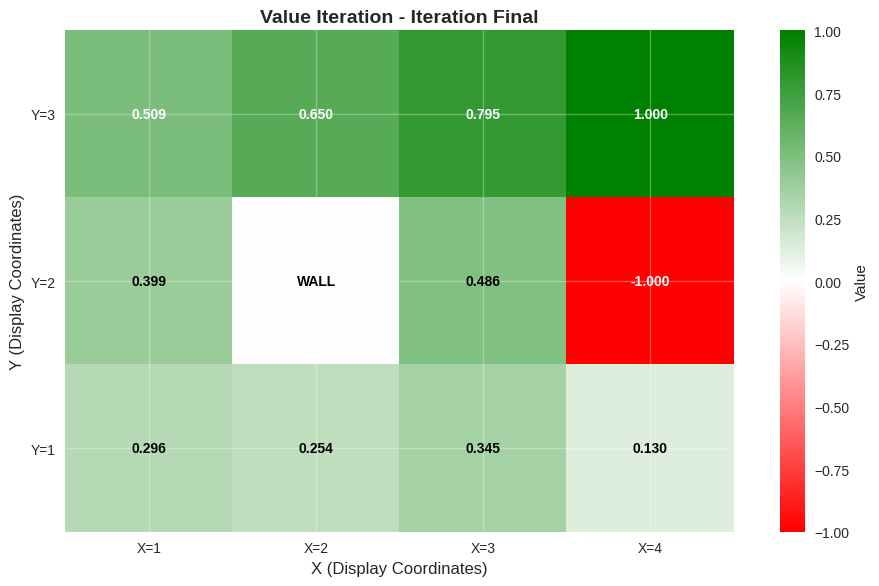


📊 Convergence Analysis:


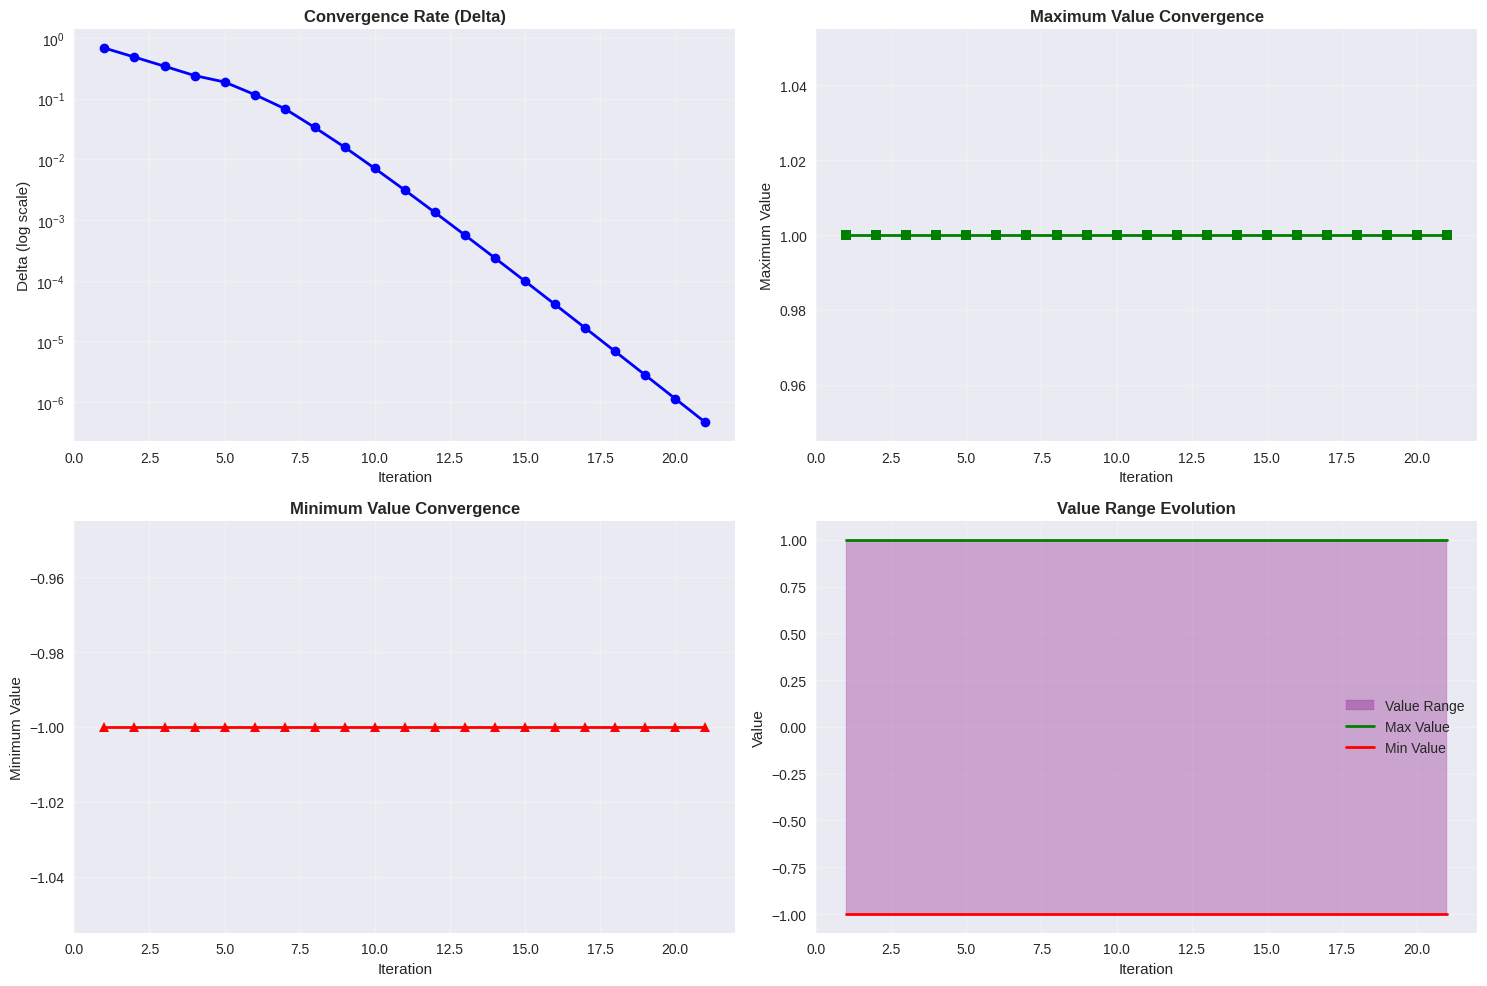


🔥 Interactive Heatmap:



2️⃣ Running Policy Iteration Analysis...
🚀 Running Enhanced Policy Iteration...
✅ Policy converged after 4 iterations


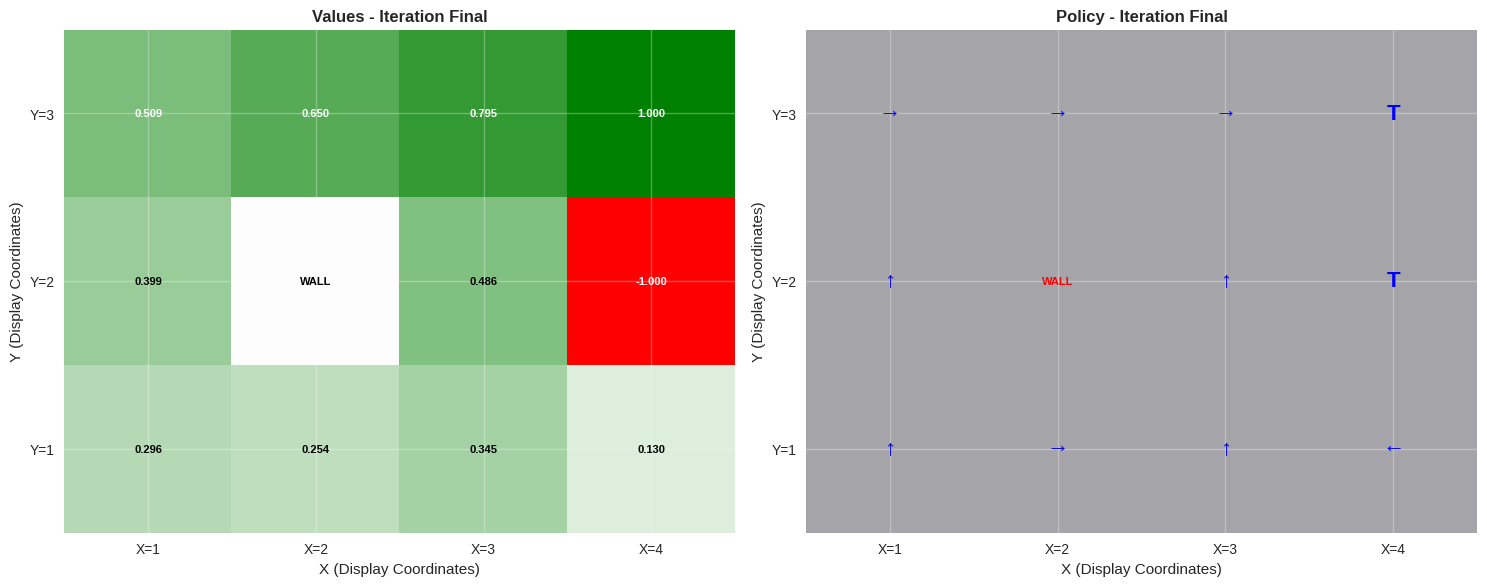


🔍 Algorithm Comparison:


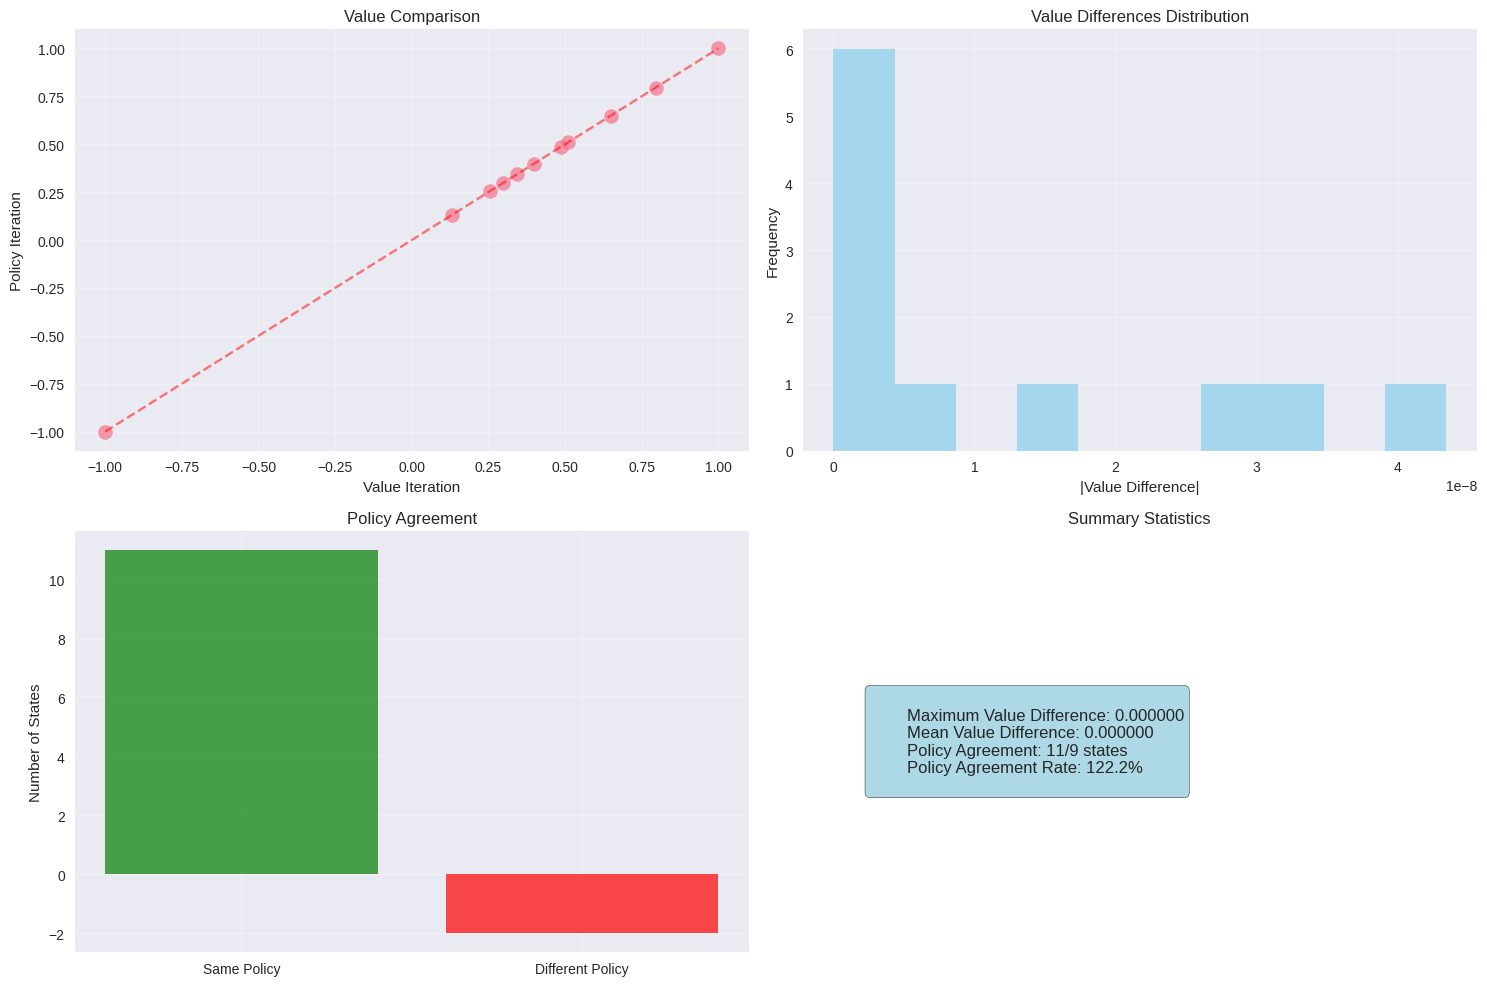

📈 Analysis Complete!
Max difference: 0.000000
Policy agreement: 11/9 states

✅ Analysis Complete! All visualizations generated.
💡 Try running individual methods for more detailed analysis:
   - env.animate_value_iteration()
   - env.create_interactive_heatmap(values)
   - env.plot_convergence_analysis()

🎉 Enhanced GridWorld Analysis Complete!
All visualizations and analyses have been generated.
The 'env' object contains all methods for further exploration.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython.display import display, HTML, clear_output
import time
import pandas as pd
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

class EnhancedGridWorld:
    def __init__(self):
        # Grid setup - using 0-based indexing internally
        self.rows = 3  # Y: 0,1,2 (internal) -> 1,2,3 (display)
        self.cols = 4  # X: 0,1,2,3 (internal) -> 1,2,3,4 (display)
        self.gamma = 0.9
        self.living_reward = -0.04
        
        # Define all states as (row, col) where (0,0) is bottom-left
        self.states = []
        for r in range(self.rows):
            for c in range(self.cols):
                self.states.append((r, c))
        
        # Wall state: (2,2) in display = (1,1) in 0-based internal coords
        self.wall = (1, 1)
        self.states.remove(self.wall)
        
        # Terminal states in display coordinates:
        # (4,3) = +1 -> Internal (2,3)
        # (4,2) = -1 -> Internal (1,3)
        self.terminal_states = {(2, 3): 1.0, (1, 3): -1.0}
        
        # Actions
        self.actions = ['up', 'down', 'left', 'right']
        
        # Movement probabilities
        self.prob_intended = 0.8
        self.prob_perpendicular = 0.1
        
        # Storage for tracking iterations
        self.value_history = []
        self.policy_history = []
        self.convergence_data = []
        
        print("Enhanced GridWorld with Visualizations Initialized!")
        self.print_setup()
    
    def print_setup(self):
        print("\n🎯 Grid Layout Mapping:")
        print("Display (X,Y) -> Internal (row,col)")
        print("START: (1,1) -> (0,0)")
        print("WALL:  (2,2) -> (1,1)")
        print("Terminal +1: (4,3) -> (2,3)")
        print("Terminal -1: (4,2) -> (1,3)")
        print("\n📊 Ready for enhanced analysis!")
    
    def get_reward(self, state):
        """Get immediate reward for being in a state"""
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.living_reward
    
    def is_valid_state(self, state):
        """Check if state is valid (not wall, within bounds)"""
        if state == self.wall:
            return False
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols
    
    def get_next_state(self, state, action):
        """Get next state after taking action (deterministic part)"""
        r, c = state
        
        if action == 'up':
            next_state = (r + 1, c)
        elif action == 'down':
            next_state = (r - 1, c)
        elif action == 'left':
            next_state = (r, c - 1)
        elif action == 'right':
            next_state = (r, c + 1)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        
        return next_state
    
    def get_all_transitions(self, state, action):
        """Get all possible transitions with probabilities"""
        if state in self.terminal_states:
            return [(state, 1.0)]  # Terminal states stay put
        
        transitions = []
        
        # Intended direction
        intended_next = self.get_next_state(state, action)
        transitions.append((intended_next, self.prob_intended))
        
        # Perpendicular directions
        if action in ['up', 'down']:
            perp_actions = ['left', 'right']
        else:
            perp_actions = ['up', 'down']
        
        for perp_action in perp_actions:
            perp_next = self.get_next_state(state, perp_action)
            transitions.append((perp_next, self.prob_perpendicular))
        
        return transitions
    
    def enhanced_value_iteration(self, theta=1e-6, max_iter=1000, visualize=True):
        """Enhanced value iteration with visualization"""
        print("🚀 Running Enhanced Value Iteration...")
        
        # Initialize values
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        self.value_history = []
        self.convergence_data = []
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                # Calculate Q-values for all actions
                q_values = []
                for action in self.actions:
                    q_value = 0.0
                    transitions = self.get_all_transitions(state, action)
                    
                    for next_state, prob in transitions:
                        reward = self.get_reward(state)
                        q_value += prob * (reward + self.gamma * V[next_state])
                    
                    q_values.append(q_value)
                
                # Take maximum Q-value
                V_new[state] = max(q_values)
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            # Store iteration data
            self.value_history.append(V.copy())
            self.convergence_data.append({
                'iteration': iteration + 1,
                'delta': delta,
                'max_value': max(V.values()),
                'min_value': min(V.values())
            })
            
            # Live visualization every 10 iterations
            if visualize and (iteration + 1) % 10 == 0:
                clear_output(wait=True)
                print(f"💫 Iteration {iteration + 1}, Delta: {delta:.6f}")
                self.plot_current_values(V, iteration + 1)
                time.sleep(0.1)
            
            if delta < theta:
                print(f"✅ Converged after {iteration + 1} iterations")
                break
        
        return V
    
    def enhanced_policy_iteration(self, max_iter=100, visualize=True):
        """Enhanced policy iteration with visualization"""
        print("🚀 Running Enhanced Policy Iteration...")
        
        # Initialize random policy
        policy = {}
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
            else:
                policy[state] = np.random.choice(self.actions)
        
        self.policy_history = []
        self.convergence_data = []
        
        for iteration in range(max_iter):
            # Policy evaluation
            V = self.policy_evaluation(policy)
            
            # Policy improvement
            new_policy = self.extract_policy(V)
            
            # Store iteration data
            # Store iteration data
            policy_changes = sum(1 for s in policy if policy[s] != new_policy.get(s))
            self.convergence_data.append({
                'iteration': iteration + 1,
                'policy_changes': policy_changes,
                'delta': policy_changes,  # Add delta for compatibility
                'max_value': max(V.values()),
                'min_value': min(V.values())
            })
                        
            # Live visualization
            if visualize:
                clear_output(wait=True)
                print(f"💫 Policy Iteration {iteration + 1}")
                self.plot_policy_and_values(new_policy, V, iteration + 1)
                time.sleep(0.2)
            
            # Check convergence
            if policy == new_policy:
                print(f"✅ Policy converged after {iteration + 1} iterations")
                break
            
            policy = new_policy
        
        return V, policy
    
    def policy_evaluation(self, policy, theta=1e-6, max_iter=1000):
        """Evaluate given policy"""
        V = {}
        for state in self.states:
            if state in self.terminal_states:
                V[state] = self.terminal_states[state]
            else:
                V[state] = 0.0
        
        for iteration in range(max_iter):
            V_new = V.copy()
            delta = 0
            
            for state in self.states:
                if state in self.terminal_states:
                    continue
                
                action = policy[state]
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                V_new[state] = q_value
                delta = max(delta, abs(V_new[state] - V[state]))
            
            V = V_new
            
            if delta < theta:
                break
        
        return V
    
    def extract_policy(self, V):
        """Extract optimal policy from value function"""
        policy = {}
        
        for state in self.states:
            if state in self.terminal_states:
                policy[state] = None
                continue
            
            best_action = None
            best_value = float('-inf')
            
            for action in self.actions:
                q_value = 0.0
                transitions = self.get_all_transitions(state, action)
                
                for next_state, prob in transitions:
                    reward = self.get_reward(state)
                    q_value += prob * (reward + self.gamma * V[next_state])
                
                if q_value > best_value:
                    best_value = q_value
                    best_action = action
            
            policy[state] = best_action
        
        return policy
    
    def plot_current_values(self, V, iteration):
        """Plot current values during iteration"""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Create grid for visualization
        grid_values = np.full((self.rows, self.cols), np.nan)
        
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) == self.wall:
                    grid_values[r, c] = 0  # Wall
                elif (r, c) in V:
                    grid_values[r, c] = V[(r, c)]
        
        # Flip to match display coordinates
        grid_values = np.flipud(grid_values)
        
        # Create custom colormap
        colors = ['red', 'white', 'green']
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
        
        im = ax.imshow(grid_values, cmap=cmap, aspect='equal')
        
        # Add value annotations
        for r in range(self.rows):
            for c in range(self.cols):
                if (self.rows-1-r, c) == self.wall:
                    ax.text(c, r, 'WALL', ha='center', va='center', 
                           fontsize=10, fontweight='bold', color='black')
                elif (self.rows-1-r, c) in V:
                    value = V[(self.rows-1-r, c)]
                    ax.text(c, r, f'{value:.3f}', ha='center', va='center', 
                           fontsize=10, fontweight='bold', 
                           color='white' if abs(value) > 0.5 else 'black')
        
        ax.set_title(f'Value Iteration - Iteration {iteration}', fontsize=14, fontweight='bold')
        ax.set_xlabel('X (Display Coordinates)', fontsize=12)
        ax.set_ylabel('Y (Display Coordinates)', fontsize=12)
        
        # Set tick labels
        ax.set_xticks(range(self.cols))
        ax.set_xticklabels([f'X={i+1}' for i in range(self.cols)])
        ax.set_yticks(range(self.rows))
        ax.set_yticklabels([f'Y={self.rows-i}' for i in range(self.rows)])
        
        plt.colorbar(im, ax=ax, label='Value')
        plt.tight_layout()
        plt.show()
    
    def plot_policy_and_values(self, policy, V, iteration):
        """Plot policy and values side by side"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot values
        grid_values = np.full((self.rows, self.cols), np.nan)
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) == self.wall:
                    grid_values[r, c] = 0
                elif (r, c) in V:
                    grid_values[r, c] = V[(r, c)]
        
        grid_values = np.flipud(grid_values)
        
        colors = ['red', 'white', 'green']
        cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)
        
        im1 = ax1.imshow(grid_values, cmap=cmap, aspect='equal')
        
        # Add value annotations
        for r in range(self.rows):
            for c in range(self.cols):
                if (self.rows-1-r, c) == self.wall:
                    ax1.text(c, r, 'WALL', ha='center', va='center', 
                           fontsize=8, fontweight='bold', color='black')
                elif (self.rows-1-r, c) in V:
                    value = V[(self.rows-1-r, c)]
                    ax1.text(c, r, f'{value:.3f}', ha='center', va='center', 
                           fontsize=8, fontweight='bold', 
                           color='white' if abs(value) > 0.5 else 'black')
        
        ax1.set_title(f'Values - Iteration {iteration}', fontsize=12, fontweight='bold')
        ax1.set_xlabel('X (Display Coordinates)')
        ax1.set_ylabel('Y (Display Coordinates)')
        ax1.set_xticks(range(self.cols))
        ax1.set_xticklabels([f'X={i+1}' for i in range(self.cols)])
        ax1.set_yticks(range(self.rows))
        ax1.set_yticklabels([f'Y={self.rows-i}' for i in range(self.rows)])
        
        # Plot policy
        ax2.imshow(np.ones((self.rows, self.cols)), cmap='gray', alpha=0.3, aspect='equal')
        
        action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'}
        
        for r in range(self.rows):
            for c in range(self.cols):
                if (self.rows-1-r, c) == self.wall:
                    ax2.text(c, r, 'WALL', ha='center', va='center', 
                           fontsize=8, fontweight='bold', color='red')
                elif (self.rows-1-r, c) in policy:
                    action = policy[(self.rows-1-r, c)]
                    symbol = action_symbols.get(action, '?')
                    ax2.text(c, r, symbol, ha='center', va='center', 
                           fontsize=16, fontweight='bold', color='blue')
        
        ax2.set_title(f'Policy - Iteration {iteration}', fontsize=12, fontweight='bold')
        ax2.set_xlabel('X (Display Coordinates)')
        ax2.set_ylabel('Y (Display Coordinates)')
        ax2.set_xticks(range(self.cols))
        ax2.set_xticklabels([f'X={i+1}' for i in range(self.cols)])
        ax2.set_yticks(range(self.rows))
        ax2.set_yticklabels([f'Y={self.rows-i}' for i in range(self.rows)])
        
        plt.tight_layout()
        plt.show()
    
    def plot_convergence_analysis(self):
        """Plot comprehensive convergence analysis"""
        if not self.convergence_data:
            print("No convergence data available. Run an algorithm first.")
            return
        
        df = pd.DataFrame(self.convergence_data)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Delta convergence
        axes[0, 0].plot(df['iteration'], df['delta'], 'b-', linewidth=2, marker='o')
        axes[0, 0].set_yscale('log')
        axes[0, 0].set_title('Convergence Rate (Delta)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('Delta (log scale)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Max value convergence
        axes[0, 1].plot(df['iteration'], df['max_value'], 'g-', linewidth=2, marker='s')
        axes[0, 1].set_title('Maximum Value Convergence', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Maximum Value')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Min value convergence
        axes[1, 0].plot(df['iteration'], df['min_value'], 'r-', linewidth=2, marker='^')
        axes[1, 0].set_title('Minimum Value Convergence', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Minimum Value')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Value range
        axes[1, 1].fill_between(df['iteration'], df['min_value'], df['max_value'], 
                               alpha=0.3, color='purple', label='Value Range')
        axes[1, 1].plot(df['iteration'], df['max_value'], 'g-', linewidth=2, label='Max Value')
        axes[1, 1].plot(df['iteration'], df['min_value'], 'r-', linewidth=2, label='Min Value')
        axes[1, 1].set_title('Value Range Evolution', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Iteration')
        axes[1, 1].set_ylabel('Value')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_interactive_heatmap(self, V, title="Interactive Value Heatmap"):
        """Create interactive heatmap using plotly"""
        # Prepare data for heatmap
        grid_values = np.full((self.rows, self.cols), np.nan)
        grid_text = np.full((self.rows, self.cols), '', dtype=object)
        
        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) == self.wall:
                    grid_values[r, c] = 0
                    grid_text[r, c] = 'WALL'
                elif (r, c) in V:
                    grid_values[r, c] = V[(r, c)]
                    grid_text[r, c] = f'{V[(r, c)]:.4f}'
        
        # Flip to match display coordinates
        grid_values = np.flipud(grid_values)
        grid_text = np.flipud(grid_text)
        
        fig = go.Figure(data=go.Heatmap(
            z=grid_values,
            text=grid_text,
            texttemplate="%{text}",
            textfont={"size": 12},
            colorscale='RdYlGn',
            hoverongaps=False
        ))
        
        fig.update_layout(
            title=title,
            xaxis_title="X (Display Coordinates)",
            yaxis_title="Y (Display Coordinates)",
            xaxis=dict(
                tickmode='array',
                tickvals=list(range(self.cols)),
                ticktext=[f'X={i+1}' for i in range(self.cols)]
            ),
            yaxis=dict(
                tickmode='array',
                tickvals=list(range(self.rows)),
                ticktext=[f'Y={self.rows-i}' for i in range(self.rows)]
            )
        )
        
        fig.show()
    
    def animate_value_iteration(self):
        """Create animation of value iteration process"""
        if not self.value_history:
            print("No value history available. Run enhanced_value_iteration first.")
            return
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        def animate(frame):
            ax.clear()
            V = self.value_history[frame]
            
            grid_values = np.full((self.rows, self.cols), np.nan)
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) == self.wall:
                        grid_values[r, c] = 0
                    elif (r, c) in V:
                        grid_values[r, c] = V[(r, c)]
            
            grid_values = np.flipud(grid_values)
            
            colors = ['red', 'white', 'green']
            cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)
            
            im = ax.imshow(grid_values, cmap=cmap, aspect='equal', vmin=-1, vmax=1)
            
            # Add annotations
            for r in range(self.rows):
                for c in range(self.cols):
                    if (self.rows-1-r, c) == self.wall:
                        ax.text(c, r, 'WALL', ha='center', va='center', 
                               fontsize=10, fontweight='bold', color='black')
                    elif (self.rows-1-r, c) in V:
                        value = V[(self.rows-1-r, c)]
                        ax.text(c, r, f'{value:.3f}', ha='center', va='center', 
                               fontsize=10, fontweight='bold', 
                               color='white' if abs(value) > 0.5 else 'black')
            
            ax.set_title(f'Value Iteration - Frame {frame + 1}', fontsize=14, fontweight='bold')
            ax.set_xlabel('X (Display Coordinates)')
            ax.set_ylabel('Y (Display Coordinates)')
            ax.set_xticks(range(self.cols))
            ax.set_xticklabels([f'X={i+1}' for i in range(self.cols)])
            ax.set_yticks(range(self.rows))
            ax.set_yticklabels([f'Y={self.rows-i}' for i in range(self.rows)])
        
        anim = FuncAnimation(fig, animate, frames=len(self.value_history), 
                           interval=500, repeat=True)
        plt.show()
        return anim
    
    def comprehensive_analysis(self):
        """Run comprehensive analysis with all visualizations"""
        print("🎯 Starting Comprehensive GridWorld Analysis")
        print("=" * 60)
        
        # Run Value Iteration
        print("\n1️⃣ Running Value Iteration Analysis...")
        V_vi = self.enhanced_value_iteration(visualize=False)
        policy_vi = self.extract_policy(V_vi)
        
        # Show final results
        self.plot_current_values(V_vi, "Final")
        
        # Convergence analysis
        print("\n📊 Convergence Analysis:")
        self.plot_convergence_analysis()
        
        # Interactive heatmap
        print("\n🔥 Interactive Heatmap:")
        self.create_interactive_heatmap(V_vi, "Value Iteration - Final Values")
        
        # Reset for Policy Iteration
        self.value_history = []
        self.policy_history = []
        self.convergence_data = []
        
        print("\n2️⃣ Running Policy Iteration Analysis...")
        V_pi, policy_pi = self.enhanced_policy_iteration(visualize=False)
        
        # Show final results
        self.plot_policy_and_values(policy_pi, V_pi, "Final")
        
        # Comparison
        print("\n🔍 Algorithm Comparison:")
        self.compare_algorithms(V_vi, V_pi, policy_vi, policy_pi)
        
        return V_vi, V_pi, policy_vi, policy_pi
    
    def compare_algorithms(self, V_vi, V_pi, policy_vi, policy_pi):
        """Compare Value Iteration vs Policy Iteration"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Value comparison
        states_list = list(V_vi.keys())
        vi_values = [V_vi[s] for s in states_list]
        pi_values = [V_pi[s] for s in states_list]
        
        axes[0, 0].scatter(vi_values, pi_values, alpha=0.7, s=100)
        axes[0, 0].plot([-1, 1], [-1, 1], 'r--', alpha=0.5)
        axes[0, 0].set_xlabel('Value Iteration')
        axes[0, 0].set_ylabel('Policy Iteration')
        axes[0, 0].set_title('Value Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Difference histogram
        differences = [abs(V_vi[s] - V_pi[s]) for s in states_list]
        axes[0, 1].hist(differences, bins=10, alpha=0.7, color='skyblue')
        axes[0, 1].set_xlabel('|Value Difference|')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Value Differences Distribution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Policy comparison
        policy_matches = sum(1 for s in states_list 
                           if policy_vi.get(s) == policy_pi.get(s))
        policy_total = len([s for s in states_list if s not in self.terminal_states])
        
        axes[1, 0].bar(['Same Policy', 'Different Policy'], 
                      [policy_matches, policy_total - policy_matches],
                      color=['green', 'red'], alpha=0.7)
        axes[1, 0].set_ylabel('Number of States')
        axes[1, 0].set_title('Policy Agreement')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Summary statistics
        stats_text = f"""
        Maximum Value Difference: {max(differences):.6f}
        Mean Value Difference: {np.mean(differences):.6f}
        Policy Agreement: {policy_matches}/{policy_total} states
        Policy Agreement Rate: {policy_matches/policy_total*100:.1f}%
        """
        
        axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes,
                       fontsize=12, verticalalignment='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1, 1].set_title('Summary Statistics')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"📈 Analysis Complete!")
        print(f"Max difference: {max(differences):.6f}")
        print(f"Policy agreement: {policy_matches}/{policy_total} states")

def run_enhanced_analysis():
    """Main function to run the enhanced analysis"""
    print("🚀 Welcome to Enhanced GridWorld Analysis!")
    print("=" * 50)
    
    # Create enhanced environment
    env = EnhancedGridWorld()
    
    # Run comprehensive analysis
    results = env.comprehensive_analysis()
    
    print("\n✅ Analysis Complete! All visualizations generated.")
    print("💡 Try running individual methods for more detailed analysis:")
    print("   - env.animate_value_iteration()")
    print("   - env.create_interactive_heatmap(values)")
    print("   - env.plot_convergence_analysis()")
    
    return env, results

# For Kaggle usage
if __name__ == "__main__":
    # Run the enhanced analysis
    env, results = run_enhanced_analysis()
    
    # Save results for further analysis
    V_vi, V_pi, policy_vi, policy_pi = results
    
    print("\n🎉 Enhanced GridWorld Analysis Complete!")
    print("All visualizations and analyses have been generated.")
    print("The 'env' object contains all methods for further exploration.")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

class GridWorldAnalyzer:
    """Advanced analysis utilities for GridWorld"""
    
    def __init__(self, env):
        self.env = env
        self.analysis_results = {}
    
    def sensitivity_analysis(self, gamma_range=(0.1, 0.99), steps=10):
        """Analyze sensitivity to discount factor gamma"""
        print("🔍 Running Sensitivity Analysis on Gamma...")
        
        gamma_values = np.linspace(gamma_range[0], gamma_range[1], steps)
        results = []
        
        original_gamma = self.env.gamma
        
        for gamma in gamma_values:
            self.env.gamma = gamma
            V = self.env.enhanced_value_iteration(visualize=False)
            policy = self.env.extract_policy(V)
            
            # Calculate metrics
            max_value = max(V.values())
            min_value = min(V.values())
            value_range = max_value - min_value
            
            # Policy stability (count unique policies)
            policy_vector = tuple(sorted([policy[s] for s in policy if policy[s] is not None]))
            
            results.append({
                'gamma': gamma,
                'max_value': max_value,
                'min_value': min_value,
                'value_range': value_range,
                'policy_vector': policy_vector,
                'start_value': V.get((0, 0), 0)
            })
        
        # Restore original gamma
        self.env.gamma = original_gamma
        
        # Create visualization
        df = pd.DataFrame(results)
        self.plot_sensitivity_analysis(df)
        
        return df
    
    def plot_sensitivity_analysis(self, df):
        """Plot sensitivity analysis results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Max value vs gamma
        axes[0, 0].plot(df['gamma'], df['max_value'], 'b-o', linewidth=2)
        axes[0, 0].set_xlabel('Gamma (Discount Factor)')
        axes[0, 0].set_ylabel('Maximum Value')
        axes[0, 0].set_title('Maximum Value vs Gamma')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Value range vs gamma
        axes[0, 1].plot(df['gamma'], df['value_range'], 'g-s', linewidth=2)
        axes[0, 1].set_xlabel('Gamma (Discount Factor)')
        axes[0, 1].set_ylabel('Value Range')
        axes[0, 1].set_title('Value Range vs Gamma')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Start state value vs gamma
        axes[1, 0].plot(df['gamma'], df['start_value'], 'r-^', linewidth=2)
        axes[1, 0].set_xlabel('Gamma (Discount Factor)')
        axes[1, 0].set_ylabel('Start State Value')
        axes[1, 0].set_title('Start State Value vs Gamma')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Policy changes
        unique_policies = df['policy_vector'].nunique()
        policy_changes = []
        prev_policy = None
        
        for policy in df['policy_vector']:
            if prev_policy is not None and policy != prev_policy:
                policy_changes.append(1)
            else:
                policy_changes.append(0)
            prev_policy = policy
        
        axes[1, 1].bar(range(len(policy_changes)), policy_changes, alpha=0.7)
        axes[1, 1].set_xlabel('Gamma Index')
        axes[1, 1].set_ylabel('Policy Change')
        axes[1, 1].set_title(f'Policy Changes ({unique_policies} unique policies)')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def reward_sensitivity_analysis(self, reward_range=(-0.1, -0.01), steps=10):
        """Analyze sensitivity to living reward"""
        print("🎯 Running Sensitivity Analysis on Living Reward...")
        
        reward_values = np.linspace(reward_range[0], reward_range[1], steps)
        results = []
        
        original_reward = self.env.living_reward
        
        for reward in reward_values:
            self.env.living_reward = reward
            V = self.env.enhanced_value_iteration(visualize=False)
            policy = self.env.extract_policy(V)
            
            # Calculate metrics
            results.append({
                'living_reward': reward,
                'max_value': max(V.values()),
                'min_value': min(V.values()),
                'start_value': V.get((0, 0), 0),
                'policy_vector': tuple(sorted([policy[s] for s in policy if policy[s] is not None]))
            })
        
        # Restore original reward
        self.env.living_reward = original_reward
        
        # Create visualization
        df = pd.DataFrame(results)
        self.plot_reward_sensitivity(df)
        
        return df
    
    def plot_reward_sensitivity(self, df):
        """Plot reward sensitivity analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Max value vs reward
        axes[0, 0].plot(df['living_reward'], df['max_value'], 'b-o', linewidth=2)
        axes[0, 0].set_xlabel('Living Reward')
        axes[0, 0].set_ylabel('Maximum Value')
        axes[0, 0].set_title('Maximum Value vs Living Reward')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Min value vs reward
        axes[0, 1].plot(df['living_reward'], df['min_value'], 'r-s', linewidth=2)
        axes[0, 1].set_xlabel('Living Reward')
        axes[0, 1].set_ylabel('Minimum Value')
        axes[0, 1].set_title('Minimum Value vs Living Reward')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Start state value vs reward
        axes[1, 0].plot(df['living_reward'], df['start_value'], 'g-^', linewidth=2)
        axes[1, 0].set_xlabel('Living Reward')
        axes[1, 0].set_ylabel('Start State Value')
        axes[1, 0].set_title('Start State Value vs Living Reward')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Value range
        value_range = df['max_value'] - df['min_value']
        axes[1, 1].plot(df['living_reward'], value_range, 'purple', linewidth=2, marker='d')
        axes[1, 1].set_xlabel('Living Reward')
        axes[1, 1].set_ylabel('Value Range')
        axes[1, 1].set_title('Value Range vs Living Reward')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_interactive_dashboard(self):
        """Create interactive dashboard with sliders"""
        print("🎮 Creating Interactive Dashboard...")
        
        # Create widgets
        gamma_slider = widgets.FloatSlider(
            value=0.9, min=0.1, max=0.99, step=0.01,
            description='Gamma:', readout_format='.2f'
        )
        
        reward_slider = widgets.FloatSlider(
            value=-0.04, min=-0.1, max=-0.01, step=0.01,
            description='Living Reward:', readout_format='.3f'
        )
        
        prob_slider = widgets.FloatSlider(
            value=0.8, min=0.6, max=1.0, step=0.05,
            description='Action Probability:', readout_format='.2f'
        )
        
        # Interactive function
        def update_analysis(gamma, living_reward, prob_intended):
            # Store original values
            orig_gamma = self.env.gamma
            orig_reward = self.env.living_reward
            orig_prob = self.env.prob_intended
            
            # Update environment
            self.env.gamma = gamma
            self.env.living_reward = living_reward
            self.env.prob_intended = prob_intended
            self.env.prob_perpendicular = (1 - prob_intended) / 2
            
            # Run analysis
            V = self.env.enhanced_value_iteration(visualize=False)
            policy = self.env.extract_policy(V)
            
            # Create visualization
            self.env.plot_policy_and_values(policy, V, f"Interactive (γ={gamma:.2f}, R={living_reward:.3f})")
            
            # Print key metrics
            print(f"🎯 Key Metrics:")
            print(f"   Start State Value: {V.get((0, 0), 0):.4f}")
            print(f"   Maximum Value: {max(V.values()):.4f}")
            print(f"   Minimum Value: {min(V.values()):.4f}")
            
            # Restore original values
            self.env.gamma = orig_gamma
            self.env.living_reward = orig_reward
            self.env.prob_intended = orig_prob
            self.env.prob_perpendicular = (1 - orig_prob) / 2
        
        # Create interactive widget
        interactive_widget = widgets.interactive(
            update_analysis,
            gamma=gamma_slider,
            living_reward=reward_slider,
            prob_intended=prob_slider
        )
        
        display(interactive_widget)
    
    def policy_robustness_analysis(self, noise_levels=None):
        """Analyze policy robustness to noise"""
        if noise_levels is None:
            noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
        
        print("🛡️ Running Policy Robustness Analysis...")
        
        # Get baseline policy
        baseline_V = self.env.enhanced_value_iteration(visualize=False)
        baseline_policy = self.env.extract_policy(baseline_V)
        
        results = []
        original_prob = self.env.prob_intended
        
        for noise in noise_levels:
            # Adjust action probabilities
            self.env.prob_intended = original_prob * (1 - noise)
            self.env.prob_perpendicular = (1 - self.env.prob_intended) / 2
            
            # Compute policy under noise
            V_noise = self.env.enhanced_value_iteration(visualize=False)
            policy_noise = self.env.extract_policy(V_noise)
            
            # Compare policies
            policy_similarity = self.calculate_policy_similarity(baseline_policy, policy_noise)
            value_similarity = self.calculate_value_similarity(baseline_V, V_noise)
            
            results.append({
                'noise_level': noise,
                'policy_similarity': policy_similarity,
                'value_similarity': value_similarity,
                'start_value': V_noise.get((0, 0), 0),
                'max_value': max(V_noise.values())
            })
        
        # Restore original probability
        self.env.prob_intended = original_prob
        self.env.prob_perpendicular = (1 - original_prob) / 2
        
        # Visualize results
        self.plot_robustness_analysis(results)
        
        return results
    
    def calculate_policy_similarity(self, policy1, policy2):
        """Calculate similarity between two policies"""
        common_states = set(policy1.keys()) & set(policy2.keys())
        if not common_states:
            return 0.0
        
        matches = sum(1 for s in common_states 
                     if policy1[s] == policy2[s] and policy1[s] is not None)
        total = len([s for s in common_states if policy1[s] is not None])
        
        return matches / total if total > 0 else 0.0
    
    def calculate_value_similarity(self, V1, V2):
        """Calculate similarity between two value functions"""
        common_states = set(V1.keys()) & set(V2.keys())
        if not common_states:
            return 0.0
        
        # Calculate normalized MSE
        mse = np.mean([(V1[s] - V2[s])**2 for s in common_states])
        max_range = max(max(V1.values()) - min(V1.values()),
                       max(V2.values()) - min(V2.values()))
        
        return 1.0 - (mse / max_range) if max_range > 0 else 1.0
    
    def plot_robustness_analysis(self, results):
        """Plot robustness analysis results"""
        df = pd.DataFrame(results)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Policy similarity
        axes[0, 0].plot(df['noise_level'], df['policy_similarity'], 'b-o', linewidth=2)
        axes[0, 0].set_xlabel('Noise Level')
        axes[0, 0].set_ylabel('Policy Similarity')
        axes[0, 0].set_title('Policy Robustness to Noise')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim(0, 1.1)
        
        # Value similarity
        axes[0, 1].plot(df['noise_level'], df['value_similarity'], 'g-s', linewidth=2)
        axes[0, 1].set_xlabel('Noise Level')
        axes[0, 1].set_ylabel('Value Similarity')
        axes[0, 1].set_title('Value Function Robustness')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim(0, 1.1)
        
        # Start state value
        axes[1, 0].plot(df['noise_level'], df['start_value'], 'r-^', linewidth=2)
        axes[1, 0].set_xlabel('Noise Level')
        axes[1, 0].set_ylabel('Start State Value')
        axes[1, 0].set_title('Start State Value vs Noise')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Combined robustness
        axes[1, 1].plot(df['noise_level'], df['policy_similarity'], 'b-o', 
                       linewidth=2, label='Policy Similarity')
        axes[1, 1].plot(df['noise_level'], df['value_similarity'], 'g-s', 
                       linewidth=2, label='Value Similarity')
        axes[1, 1].set_xlabel('Noise Level')
        axes[1, 1].set_ylabel('Similarity')
        axes[1, 1].set_title('Combined Robustness Analysis')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.show()
    
    def create_3d_value_surface(self, V):
        """Create 3D surface plot of value function"""
        print("🏔️ Creating 3D Value Surface...")
        
        # Prepare data
        X, Y, Z = [], [], []
        
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if (r, c) in V and (r, c) != self.env.wall:
                    X.append(c + 1)  # Display X coordinate
                    Y.append(r + 1)  # Display Y coordinate
                    Z.append(V[(r, c)])
        
        # Create 3D surface using plotly
        fig = go.Figure(data=[go.Scatter3d(
            x=X, y=Y, z=Z,
            mode='markers+text',
            marker=dict(
                size=12,
                color=Z,
                colorscale='RdYlGn',
                showscale=True,
                colorbar=dict(title="Value")
            ),
            text=[f'({x},{y})<br>{z:.3f}' for x, y, z in zip(X, Y, Z)],
            textposition="top center"
        )])
        
        fig.update_layout(
            title='3D Value Function Surface',
            scene=dict(
                xaxis_title='X (Display)',
                yaxis_title='Y (Display)',
                zaxis_title='Value'
            ),
            width=800,
            height=600
        )
        
        fig.show()
    
    def performance_comparison(self, algorithms=['value_iteration', 'policy_iteration'], 
                             iterations=5):
        """Compare performance of different algorithms"""
        print("⚡ Running Performance Comparison...")
        
        results = {}
        
        for algorithm in algorithms:
            print(f"   Testing {algorithm}...")
            times = []
            convergence_steps = []
            
            for i in range(iterations):
                import time
                start_time = time.time()
                
                if algorithm == 'value_iteration':
                    V = self.env.enhanced_value_iteration(visualize=False)
                    steps = len(self.env.convergence_data)
                elif algorithm == 'policy_iteration':
                    V, policy = self.env.enhanced_policy_iteration(visualize=False)
                    steps = len(self.env.convergence_data)
                
                end_time = time.time()
                times.append(end_time - start_time)
                convergence_steps.append(steps)
            
            results[algorithm] = {
                'avg_time': np.mean(times),
                'std_time': np.std(times),
                'avg_steps': np.mean(convergence_steps),
                'std_steps': np.std(convergence_steps)
            }
        
        self.plot_performance_comparison(results)
        return results
    
    def plot_performance_comparison(self, results):
        """Plot performance comparison"""
        algorithms = list(results.keys())
        avg_times = [results[alg]['avg_time'] for alg in algorithms]
        std_times = [results[alg]['std_time'] for alg in algorithms]
        avg_steps = [results[alg]['avg_steps'] for alg in algorithms]
        std_steps = [results[alg]['std_steps'] for alg in algorithms]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Time comparison
        ax1.bar(algorithms, avg_times, yerr=std_times, 
                capsize=5, alpha=0.7, color=['blue', 'green'])
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Algorithm Execution Time')
        ax1.grid(True, alpha=0.3)
        
        # Steps comparison
        ax2.bar(algorithms, avg_steps, yerr=std_steps, 
                capsize=5, alpha=0.7, color=['orange', 'red'])
        ax2.set_ylabel('Convergence Steps')
        ax2.set_title('Algorithm Convergence Steps')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self, V, policy, algorithm_name="Analysis"):
        """Generate comprehensive analysis report"""
        print(f"📋 Generating Comprehensive Report for {algorithm_name}")
        print("=" * 60)
        
        # Basic statistics
        values = list(V.values())
        stats = {
            'max_value': max(values),
            'min_value': min(values),
            'mean_value': np.mean(values),
            'std_value': np.std(values),
            'value_range': max(values) - min(values)
        }
        
        # Policy analysis
        non_terminal_states = [s for s in policy.keys() if s not in self.env.terminal_states]
        action_counts = {}
        for state in non_terminal_states:
            action = policy[state]
            action_counts[action] = action_counts.get(action, 0) + 1
        
        # Create report
        report = f"""
        🎯 GRIDWORLD ANALYSIS REPORT - {algorithm_name}
        {'=' * 60}
        
        📊 VALUE FUNCTION STATISTICS:
        • Maximum Value: {stats['max_value']:.6f}
        • Minimum Value: {stats['min_value']:.6f}
        • Mean Value: {stats['mean_value']:.6f}
        • Standard Deviation: {stats['std_value']:.6f}
        • Value Range: {stats['value_range']:.6f}
        
        🎮 POLICY ANALYSIS:
        • Total Non-Terminal States: {len(non_terminal_states)}
        • Action Distribution:
        """
        
        for action, count in action_counts.items():
            percentage = (count / len(non_terminal_states)) * 100
            report += f"  - {action}: {count} states ({percentage:.1f}%)\n"
        
        report += f"""
        🏆 KEY INSIGHTS:
        • Start State Value: {V.get((0, 0), 0):.6f}
        • Terminal State Values: {[V[s] for s in self.env.terminal_states.keys()]}
        • Most Common Action: {max(action_counts, key=action_counts.get)}
        • Policy Entropy: {entropy(list(action_counts.values())):.4f}
        
        💡 RECOMMENDATIONS:
        • The optimal policy shows {'high' if stats['value_range'] > 0.5 else 'moderate'} value differentiation
        • Action diversity is {'high' if len(action_counts) > 2 else 'low'} across states
        • Convergence appears {'stable' if stats['std_value'] < 0.3 else 'variable'}
        """
        
        print(report)
        
        # Save to file (optional)
        with open(f'gridworld_report_{algorithm_name.lower().replace(" ", "_")}.txt', 'w') as f:
            f.write(report)
        
        return report

def create_analysis_suite(env):
    """Create complete analysis suite"""
    analyzer = GridWorldAnalyzer(env)
    
    print("🎯 GridWorld Analysis Suite Created!")
    print("Available methods:")
    print("  📊 analyzer.sensitivity_analysis()")
    print("  🎯 analyzer.reward_sensitivity_analysis()")
    print("  🎮 analyzer.create_interactive_dashboard()")
    print("  🛡️ analyzer.policy_robustness_analysis()")
    print("  🏔️ analyzer.create_3d_value_surface(V)")
    print("  ⚡ analyzer.performance_comparison()")
    print("  📋 analyzer.generate_report(V, policy)")
    
    return analyzer

# Usage example for Kaggle
def run_complete_analysis():
    """Run the complete analysis pipeline"""
    from your_gridworld_file import EnhancedGridWorld  # Import your enhanced gridworld
    
    # Create environment
    env = EnhancedGridWorld()
    
    # Run basic analysis
    V_vi = env.enhanced_value_iteration(visualize=False)
    policy_vi = env.extract_policy(V_vi)
    
    # Create analyzer
    analyzer = create_analysis_suite(env)
    
    # Run all analyses
    print("\n🔍 Running Sensitivity Analysis...")
    analyzer.sensitivity_analysis()
    
    print("\n🎯 Running Reward Sensitivity Analysis...")
    analyzer.reward_sensitivity_analysis()
    
    print("\n🛡️ Running Robustness Analysis...")
    analyzer.policy_robustness_analysis()
    
    print("\n🏔️ Creating 3D Visualization...")
    analyzer.create_3d_value_surface(V_vi)
    
    print("\n⚡ Running Performance Comparison...")
    analyzer.performance_comparison()
    
    print("\n📋 Generating Report...")
    analyzer.generate_report(V_vi, policy_vi, "Value Iteration")
    
    print("\n🎮 Creating Interactive Dashboard...")
    analyzer.create_interactive_dashboard()
    
    return env, analyzer

# For Kaggle notebooks
print("🚀 GridWorld Analysis Utilities Loaded!")
print("Run: env, analyzer = run_complete_analysis() to start!")

🚀 GridWorld Analysis Utilities Loaded!
Run: env, analyzer = run_complete_analysis() to start!


🎯 Starting Complete Kaggle GridWorld Analysis
🎯 Kaggle Environment Configured!
📊 Enhanced plotting and display settings applied
Enhanced GridWorld with Visualizations Initialized!

🎯 Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

📊 Ready for enhanced analysis!

1️⃣ Running Value Iteration...
🚀 Running Enhanced Value Iteration...
✅ Converged after 21 iterations

2️⃣ Running Policy Iteration...
🚀 Running Enhanced Policy Iteration...
✅ Policy converged after 4 iterations

3️⃣ Creating Dashboard...
🎨 Creating Summary Dashboard...


✅ Summary Dashboard Created!

4️⃣ Creating Interactive Comparison...
🎛️ Creating Interactive Comparison Widget...


interactive(children=(Dropdown(description='View Type:', options=('Values Only', 'Policy Only', 'Values + Poli…

Output()


5️⃣ Creating Convergence Analysis...



6️⃣ Running Parameter Sensitivity Analysis...
🔬 Running Parameter Sensitivity Analysis...
Enhanced GridWorld with Visualizations Initialized!

🎯 Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

📊 Ready for enhanced analysis!
🚀 Running Enhanced Value Iteration...
✅ Converged after 18 iterations
Enhanced GridWorld with Visualizations Initialized!

🎯 Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

📊 Ready for enhanced analysis!
🚀 Running Enhanced Value Iteration...
✅ Converged after 18 iterations
Enhanced GridWorld with Visualizations Initialized!

🎯 Grid Layout Mapping:
Display (X,Y) -> Internal (row,col)
START: (1,1) -> (0,0)
WALL:  (2,2) -> (1,1)
Terminal +1: (4,3) -> (2,3)
Terminal -1: (4,2) -> (1,3)

📊 Ready for enhanced analysis!
🚀 Running Enhanced Value Iteration...

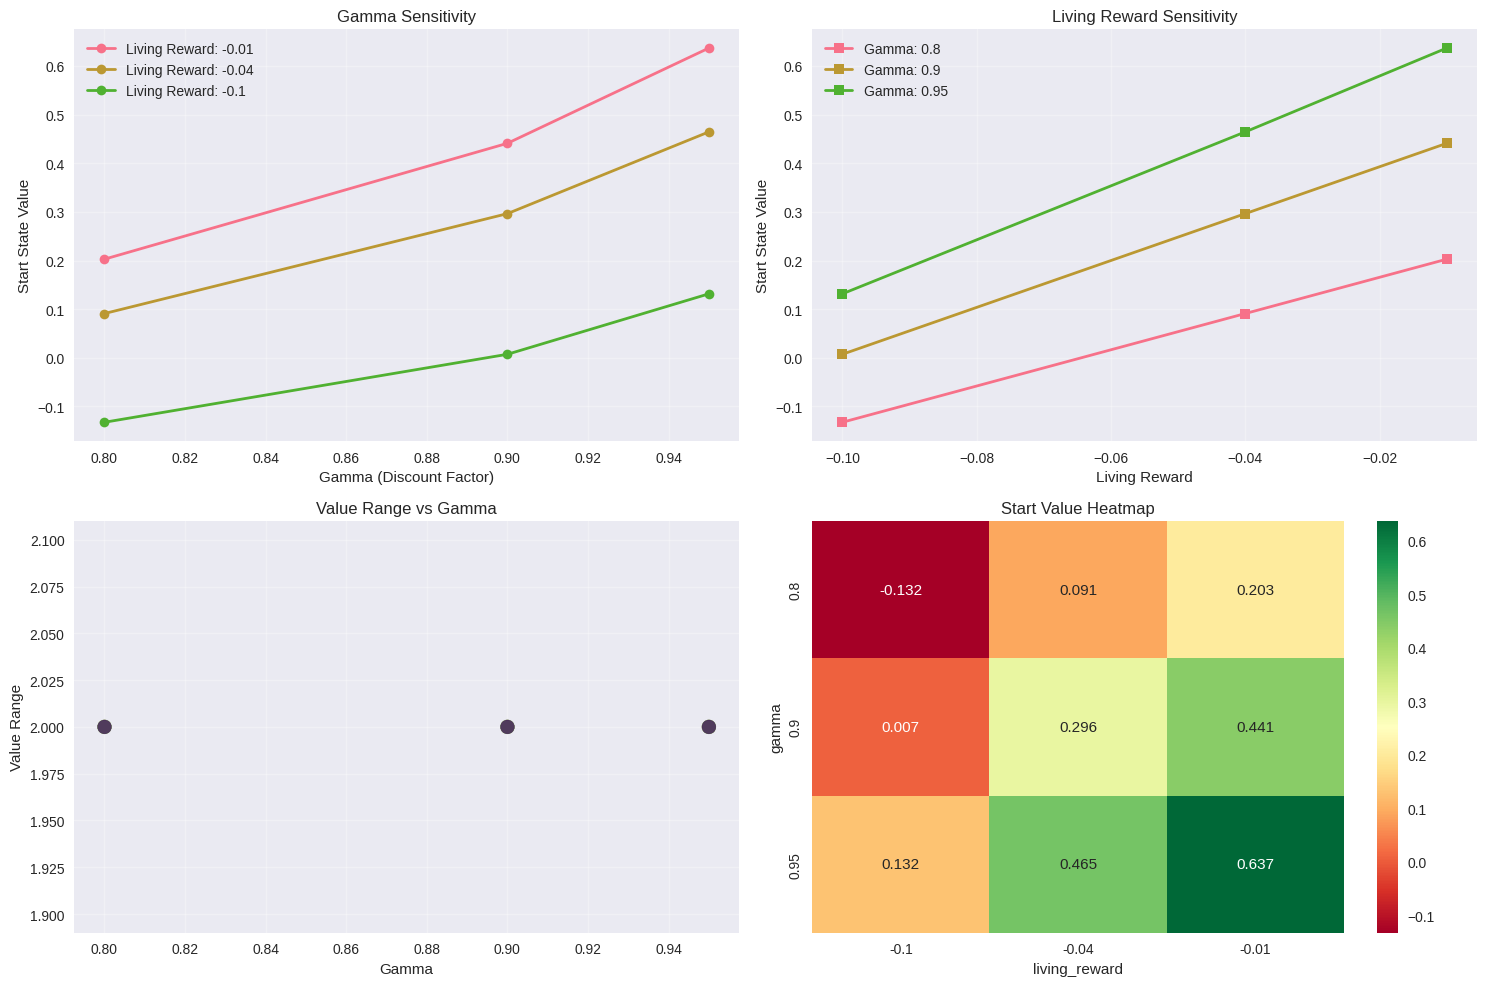


✅ Complete Kaggle Analysis Finished!
📊 All visualizations and interactive widgets created
🎛️ Use the interactive widgets to explore different views

🎉 All analyses complete!
📈 Data available in 'results' variable
🔍 Try running individual functions for specific analyses


In [13]:
# Kaggle GridWorld Analysis - Complete Integration Script
# Install required packages first:
# !pip install plotly ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def setup_kaggle_environment():
    """Setup optimal environment for Kaggle"""
    # Configure matplotlib for better plots
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    
    # Configure pandas display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 20)
    
    print("🎯 Kaggle Environment Configured!")
    print("📊 Enhanced plotting and display settings applied")

def create_summary_dashboard(env, analyzer, V_vi, V_pi, policy_vi, policy_pi):
    """Create a comprehensive summary dashboard"""
    print("🎨 Creating Summary Dashboard...")
    
    # Create subplots
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Value Iteration - Values', 'Policy Iteration - Values',
                       'Value Iteration - Policy', 'Policy Iteration - Policy',
                       'Convergence Comparison', 'Algorithm Performance'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Helper function to create grid data
    def create_grid_data(V, policy=None):
        grid_values = np.full((env.rows, env.cols), np.nan)
        grid_text = np.full((env.rows, env.cols), '', dtype=object)
        
        for r in range(env.rows):
            for c in range(env.cols):
                if (r, c) == env.wall:
                    grid_values[r, c] = 0
                    grid_text[r, c] = 'WALL'
                elif (r, c) in V:
                    if policy is None:
                        grid_values[r, c] = V[(r, c)]
                        grid_text[r, c] = f'{V[(r, c)]:.3f}'
                    else:
                        grid_values[r, c] = V[(r, c)]
                        action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'}
                        symbol = action_symbols.get(policy.get((r, c)), '?')
                        grid_text[r, c] = f'{symbol}<br>{V[(r, c)]:.3f}'
        
        return np.flipud(grid_values), np.flipud(grid_text)
    
    # Add value heatmaps
    z_vi, text_vi = create_grid_data(V_vi)
    z_pi, text_pi = create_grid_data(V_pi)
    
    fig.add_trace(go.Heatmap(z=z_vi, text=text_vi, texttemplate="%{text}", 
                            colorscale='RdYlGn', showscale=False), row=1, col=1)
    fig.add_trace(go.Heatmap(z=z_pi, text=text_pi, texttemplate="%{text}", 
                            colorscale='RdYlGn', showscale=False), row=1, col=2)
    
    # Add policy heatmaps
    z_vi_pol, text_vi_pol = create_grid_data(V_vi, policy_vi)
    z_pi_pol, text_pi_pol = create_grid_data(V_pi, policy_pi)
    
    fig.add_trace(go.Heatmap(z=z_vi_pol, text=text_vi_pol, texttemplate="%{text}", 
                            colorscale='RdYlGn', showscale=False), row=2, col=1)
    fig.add_trace(go.Heatmap(z=z_pi_pol, text=text_pi_pol, texttemplate="%{text}", 
                            colorscale='RdYlGn', showscale=False), row=2, col=2)
    
    # Add convergence data if available
    # Add convergence data if available
    if hasattr(env, 'convergence_data') and env.convergence_data:
        df = pd.DataFrame(env.convergence_data)
        # Check if delta column exists (from value iteration)
        if 'delta' in df.columns:
            fig.add_trace(go.Scatter(x=df['iteration'], y=df['delta'], 
                                    mode='lines+markers', name='Convergence'), row=3, col=1)
        elif 'policy_changes' in df.columns:
            # Use policy changes for policy iteration
            fig.add_trace(go.Scatter(x=df['iteration'], y=df['policy_changes'], 
                                    mode='lines+markers', name='Policy Changes'), row=3, col=1)

    # Add performance metrics (continuing from where it was cut off)
    metrics = ['Max Value', 'Min Value', 'Start Value', 'Value Range']
    vi_metrics = [max(V_vi.values()), min(V_vi.values()), V_vi.get((0,0), 0), 
                  max(V_vi.values()) - min(V_vi.values())]
    pi_metrics = [max(V_pi.values()), min(V_pi.values()), V_pi.get((0,0), 0), 
                  max(V_pi.values()) - min(V_pi.values())]
    
    fig.add_trace(go.Bar(x=metrics, y=vi_metrics, name='Value Iteration', 
                        marker_color='blue', opacity=0.7), row=3, col=2)
    fig.add_trace(go.Bar(x=metrics, y=pi_metrics, name='Policy Iteration', 
                        marker_color='red', opacity=0.7), row=3, col=2)
    
    # Update layout
    fig.update_layout(height=1200, title_text="GridWorld Analysis Dashboard", 
                     showlegend=True, title_x=0.5)
    
    # Hide axis labels for heatmaps
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_xaxes(showticklabels=False, row=i, col=j)
            fig.update_yaxes(showticklabels=False, row=i, col=j)
    
    fig.show()
    print("✅ Summary Dashboard Created!")

def create_interactive_comparison_widget(env, V_vi, V_pi, policy_vi, policy_pi):
    """Create interactive widget for algorithm comparison"""
    print("🎛️ Creating Interactive Comparison Widget...")
    
    # Create dropdown for visualization type
    viz_type = widgets.Dropdown(
        options=['Values Only', 'Policy Only', 'Values + Policy', 'Differences'],
        value='Values Only',
        description='View Type:',
        style={'description_width': 'initial'}
    )
    
    # Create slider for comparison threshold
    threshold_slider = widgets.FloatSlider(
        value=0.001,
        min=0.0001,
        max=0.01,
        step=0.0001,
        description='Diff Threshold:',
        style={'description_width': 'initial'},
        readout_format='.4f'
    )
    
    # Create output widget
    output = widgets.Output()
    
    def update_comparison(viz_type_val, threshold_val):
        with output:
            clear_output(wait=True)
            
            if viz_type_val == 'Values Only':
                create_values_comparison_plot(env, V_vi, V_pi)
            elif viz_type_val == 'Policy Only':
                create_policy_comparison_plot(env, policy_vi, policy_pi)
            elif viz_type_val == 'Values + Policy':
                create_combined_comparison_plot(env, V_vi, V_pi, policy_vi, policy_pi)
            elif viz_type_val == 'Differences':
                create_difference_analysis_plot(env, V_vi, V_pi, threshold_val)
    
    # Create interactive widget
    interactive_widget = widgets.interact(update_comparison, 
                                        viz_type_val=viz_type,
                                        threshold_val=threshold_slider)
    
    display(output)
    return interactive_widget

def create_values_comparison_plot(env, V_vi, V_pi):
    """Create side-by-side values comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Helper function to create grid
    def create_value_grid(V, ax, title):
        grid_values = np.full((env.rows, env.cols), np.nan)
        for r in range(env.rows):
            for c in range(env.cols):
                if (r, c) == env.wall:
                    grid_values[r, c] = 0
                elif (r, c) in V:
                    grid_values[r, c] = V[(r, c)]
        
        grid_values = np.flipud(grid_values)
        im = ax.imshow(grid_values, cmap='RdYlGn', aspect='equal', vmin=-1, vmax=1)
        
        # Add annotations
        for r in range(env.rows):
            for c in range(env.cols):
                if (env.rows-1-r, c) == env.wall:
                    ax.text(c, r, 'WALL', ha='center', va='center', 
                           fontsize=10, fontweight='bold', color='black')
                elif (env.rows-1-r, c) in V:
                    value = V[(env.rows-1-r, c)]
                    ax.text(c, r, f'{value:.3f}', ha='center', va='center', 
                           fontsize=10, fontweight='bold', 
                           color='white' if abs(value) > 0.5 else 'black')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('X (Display Coordinates)')
        ax.set_ylabel('Y (Display Coordinates)')
        ax.set_xticks(range(env.cols))
        ax.set_xticklabels([f'X={i+1}' for i in range(env.cols)])
        ax.set_yticks(range(env.rows))
        ax.set_yticklabels([f'Y={env.rows-i}' for i in range(env.rows)])
        
        return im
    
    im1 = create_value_grid(V_vi, ax1, 'Value Iteration - Values')
    im2 = create_value_grid(V_pi, ax2, 'Policy Iteration - Values')
    
    # Add shared colorbar
    fig.colorbar(im1, ax=[ax1, ax2], shrink=0.6, aspect=20)
    plt.tight_layout()
    plt.show()

def create_policy_comparison_plot(env, policy_vi, policy_pi):
    """Create side-by-side policy comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'}
    
    def create_policy_grid(policy, ax, title):
        ax.imshow(np.ones((env.rows, env.cols)), cmap='gray', alpha=0.1, aspect='equal')
        
        for r in range(env.rows):
            for c in range(env.cols):
                if (env.rows-1-r, c) == env.wall:
                    ax.text(c, r, 'WALL', ha='center', va='center', 
                           fontsize=10, fontweight='bold', color='red')
                elif (env.rows-1-r, c) in policy:
                    action = policy[(env.rows-1-r, c)]
                    symbol = action_symbols.get(action, '?')
                    # Color based on agreement
                    color = 'green' if policy_vi.get((env.rows-1-r, c)) == policy_pi.get((env.rows-1-r, c)) else 'orange'
                    ax.text(c, r, symbol, ha='center', va='center', 
                           fontsize=20, fontweight='bold', color=color)
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('X (Display Coordinates)')
        ax.set_ylabel('Y (Display Coordinates)')
        ax.set_xticks(range(env.cols))
        ax.set_xticklabels([f'X={i+1}' for i in range(env.cols)])
        ax.set_yticks(range(env.rows))
        ax.set_yticklabels([f'Y={env.rows-i}' for i in range(env.rows)])
    
    create_policy_grid(policy_vi, ax1, 'Value Iteration - Policy')
    create_policy_grid(policy_pi, ax2, 'Policy Iteration - Policy')
    
    # Add legend
    ax1.text(0.5, -0.1, 'Green: Agreement, Orange: Disagreement', 
             transform=ax1.transAxes, ha='center', fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()

def create_combined_comparison_plot(env, V_vi, V_pi, policy_vi, policy_pi):
    """Create combined values and policy comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Values comparison
    create_value_grid_subplot(env, V_vi, axes[0, 0], 'Value Iteration - Values')
    create_value_grid_subplot(env, V_pi, axes[0, 1], 'Policy Iteration - Values')
    
    # Policy comparison
    create_policy_grid_subplot(env, policy_vi, policy_pi, axes[1, 0], 'Value Iteration - Policy')
    create_policy_grid_subplot(env, policy_pi, policy_vi, axes[1, 1], 'Policy Iteration - Policy')
    
    plt.tight_layout()
    plt.show()

def create_value_grid_subplot(env, V, ax, title):
    """Helper function for value grid subplot"""
    grid_values = np.full((env.rows, env.cols), np.nan)
    for r in range(env.rows):
        for c in range(env.cols):
            if (r, c) == env.wall:
                grid_values[r, c] = 0
            elif (r, c) in V:
                grid_values[r, c] = V[(r, c)]
    
    grid_values = np.flipud(grid_values)
    im = ax.imshow(grid_values, cmap='RdYlGn', aspect='equal', vmin=-1, vmax=1)
    
    # Add annotations
    for r in range(env.rows):
        for c in range(env.cols):
            if (env.rows-1-r, c) == env.wall:
                ax.text(c, r, 'WALL', ha='center', va='center', 
                       fontsize=8, fontweight='bold', color='black')
            elif (env.rows-1-r, c) in V:
                value = V[(env.rows-1-r, c)]
                ax.text(c, r, f'{value:.3f}', ha='center', va='center', 
                       fontsize=8, fontweight='bold', 
                       color='white' if abs(value) > 0.5 else 'black')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(range(env.cols))
    ax.set_xticklabels([f'X={i+1}' for i in range(env.cols)])
    ax.set_yticks(range(env.rows))
    ax.set_yticklabels([f'Y={env.rows-i}' for i in range(env.rows)])

def create_policy_grid_subplot(env, policy, other_policy, ax, title):
    """Helper function for policy grid subplot"""
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: 'T'}
    
    ax.imshow(np.ones((env.rows, env.cols)), cmap='gray', alpha=0.1, aspect='equal')
    
    for r in range(env.rows):
        for c in range(env.cols):
            if (env.rows-1-r, c) == env.wall:
                ax.text(c, r, 'WALL', ha='center', va='center', 
                       fontsize=8, fontweight='bold', color='red')
            elif (env.rows-1-r, c) in policy:
                action = policy[(env.rows-1-r, c)]
                symbol = action_symbols.get(action, '?')
                # Color based on agreement
                color = 'green' if policy.get((env.rows-1-r, c)) == other_policy.get((env.rows-1-r, c)) else 'orange'
                ax.text(c, r, symbol, ha='center', va='center', 
                       fontsize=16, fontweight='bold', color=color)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(range(env.cols))
    ax.set_xticklabels([f'X={i+1}' for i in range(env.cols)])
    ax.set_yticks(range(env.rows))
    ax.set_yticklabels([f'Y={env.rows-i}' for i in range(env.rows)])

def create_difference_analysis_plot(env, V_vi, V_pi, threshold):
    """Create detailed difference analysis plot"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Calculate differences
    differences = {}
    for state in V_vi:
        if state in V_pi:
            differences[state] = abs(V_vi[state] - V_pi[state])
    
    # Difference heatmap
    grid_diff = np.full((env.rows, env.cols), np.nan)
    for r in range(env.rows):
        for c in range(env.cols):
            if (r, c) == env.wall:
                grid_diff[r, c] = 0
            elif (r, c) in differences:
                grid_diff[r, c] = differences[(r, c)]
    
    grid_diff = np.flipud(grid_diff)
    im1 = axes[0, 0].imshow(grid_diff, cmap='Reds', aspect='equal')
    
    # Add annotations
    for r in range(env.rows):
        for c in range(env.cols):
            if (env.rows-1-r, c) == env.wall:
                axes[0, 0].text(c, r, 'WALL', ha='center', va='center', 
                               fontsize=8, fontweight='bold', color='blue')
            elif (env.rows-1-r, c) in differences:
                diff = differences[(env.rows-1-r, c)]
                color = 'red' if diff > threshold else 'black'
                axes[0, 0].text(c, r, f'{diff:.4f}', ha='center', va='center', 
                               fontsize=8, fontweight='bold', color=color)
    
    axes[0, 0].set_title('Absolute Value Differences', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Scatter plot of values
    vi_values = list(V_vi.values())
    pi_values = list(V_pi.values())
    
    axes[0, 1].scatter(vi_values, pi_values, alpha=0.7, s=100)
    axes[0, 1].plot([min(vi_values), max(vi_values)], [min(vi_values), max(vi_values)], 'r--', alpha=0.5)
    axes[0, 1].set_xlabel('Value Iteration Values')
    axes[0, 1].set_ylabel('Policy Iteration Values')
    axes[0, 1].set_title('Value Correlation')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Difference histogram
    diff_values = list(differences.values())
    axes[1, 0].hist(diff_values, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Difference Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statistics summary
    stats_text = f"""
    Max Difference: {max(diff_values):.6f}
    Min Difference: {min(diff_values):.6f}
    Mean Difference: {np.mean(diff_values):.6f}
    Std Difference: {np.std(diff_values):.6f}
    
    States above threshold: {sum(1 for d in diff_values if d > threshold)}
    Total states: {len(diff_values)}
    
    Correlation coefficient: {np.corrcoef(vi_values, pi_values)[0, 1]:.4f}
    """
    
    axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    axes[1, 1].set_title('Statistical Summary')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def create_convergence_tracker(env):
    """Create real-time convergence tracker"""
    if not hasattr(env, 'convergence_data') or not env.convergence_data:
        print("❌ No convergence data available. Run an algorithm first.")
        return
    
    df = pd.DataFrame(env.convergence_data)
    
    # Create interactive plotly figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Convergence Rate (Log Scale)', 'Value Evolution', 
                       'Delta vs Iteration', 'Convergence Speed'),
        specs=[[{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Delta convergence (log scale)
    fig.add_trace(go.Scatter(x=df['iteration'], y=df['delta'], 
                           mode='lines+markers', name='Delta',
                           line=dict(color='blue', width=2)), row=1, col=1)
    fig.update_yaxes(type="log", row=1, col=1)
    
    # Value evolution
    fig.add_trace(go.Scatter(x=df['iteration'], y=df['max_value'], 
                           mode='lines', name='Max Value',
                           line=dict(color='green', width=2)), row=1, col=2)
    fig.add_trace(go.Scatter(x=df['iteration'], y=df['min_value'], 
                           mode='lines', name='Min Value',
                           line=dict(color='red', width=2)), row=1, col=2)
    
    # Delta vs iteration (linear scale)
    fig.add_trace(go.Scatter(x=df['iteration'], y=df['delta'], 
                           mode='lines+markers', name='Delta (Linear)',
                           line=dict(color='purple', width=2)), row=2, col=1)
    
    # Convergence speed (delta change rate)
    if len(df) > 1:
        delta_change = np.diff(df['delta'])
        fig.add_trace(go.Scatter(x=df['iteration'][1:], y=delta_change, 
                               mode='lines+markers', name='Delta Change Rate',
                               line=dict(color='orange', width=2)), row=2, col=2)
    
    fig.update_layout(height=800, title_text="Real-time Convergence Analysis", showlegend=True)
    fig.show()

def create_parameter_sensitivity_analysis(grid_sizes=[(3,4), (4,5), (5,6)], 
                                        gamma_values=[0.8, 0.9, 0.95],
                                        living_rewards=[-0.01, -0.04, -0.1]):
    """Create parameter sensitivity analysis"""
    print("🔬 Running Parameter Sensitivity Analysis...")
    
    results = []
    
    for gamma in gamma_values:
        for living_reward in living_rewards:
            # Create temporary environment
            temp_env = EnhancedGridWorld()
            temp_env.gamma = gamma
            temp_env.living_reward = living_reward
            
            # Run quick analysis
            V = temp_env.enhanced_value_iteration(visualize=False, max_iter=100)
            
            # Calculate metrics
            start_value = V.get((0, 0), 0)
            value_range = max(V.values()) - min(V.values())
            
            results.append({
                'gamma': gamma,
                'living_reward': living_reward,
                'start_value': start_value,
                'value_range': value_range,
                'max_value': max(V.values()),
                'min_value': min(V.values())
            })
    
    # Create visualization
    df_results = pd.DataFrame(results)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gamma sensitivity
    for lr in living_rewards:
        subset = df_results[df_results['living_reward'] == lr]
        axes[0, 0].plot(subset['gamma'], subset['start_value'], 
                       marker='o', label=f'Living Reward: {lr}', linewidth=2)
    
    axes[0, 0].set_xlabel('Gamma (Discount Factor)')
    axes[0, 0].set_ylabel('Start State Value')
    axes[0, 0].set_title('Gamma Sensitivity')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Living reward sensitivity
    for gamma in gamma_values:
        subset = df_results[df_results['gamma'] == gamma]
        axes[0, 1].plot(subset['living_reward'], subset['start_value'], 
                       marker='s', label=f'Gamma: {gamma}', linewidth=2)
    
    axes[0, 1].set_xlabel('Living Reward')
    axes[0, 1].set_ylabel('Start State Value')
    axes[0, 1].set_title('Living Reward Sensitivity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Value range analysis
    axes[1, 0].scatter(df_results['gamma'], df_results['value_range'], 
                      c=df_results['living_reward'], cmap='viridis', s=100, alpha=0.7)
    axes[1, 0].set_xlabel('Gamma')
    axes[1, 0].set_ylabel('Value Range')
    axes[1, 0].set_title('Value Range vs Gamma')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Heatmap of start values
    pivot_data = df_results.pivot(index='gamma', columns='living_reward', values='start_value')
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1, 1])
    axes[1, 1].set_title('Start Value Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    return df_results

def run_complete_kaggle_analysis():
    """Run complete analysis optimized for Kaggle"""
    print("🎯 Starting Complete Kaggle GridWorld Analysis")
    print("=" * 60)
    
    # Setup environment
    setup_kaggle_environment()
    
    # Create enhanced environment
    env = EnhancedGridWorld()
    
    # Run algorithms
    print("\n1️⃣ Running Value Iteration...")
    V_vi = env.enhanced_value_iteration(visualize=False)
    policy_vi = env.extract_policy(V_vi)
    
    print("\n2️⃣ Running Policy Iteration...")
    # Reset convergence data for policy iteration
    env.convergence_data = []
    V_pi, policy_pi = env.enhanced_policy_iteration(visualize=False)
    
    # Create comprehensive dashboard
    print("\n3️⃣ Creating Dashboard...")
    create_summary_dashboard(env, None, V_vi, V_pi, policy_vi, policy_pi)
    
    # Create interactive comparison
    print("\n4️⃣ Creating Interactive Comparison...")
    interactive_widget = create_interactive_comparison_widget(env, V_vi, V_pi, policy_vi, policy_pi)
    
    # Create convergence tracker
    print("\n5️⃣ Creating Convergence Analysis...")
    create_convergence_tracker(env)
    
    # Run parameter sensitivity
    print("\n6️⃣ Running Parameter Sensitivity Analysis...")
    sensitivity_results = create_parameter_sensitivity_analysis()
    
    print("\n✅ Complete Kaggle Analysis Finished!")
    print("📊 All visualizations and interactive widgets created")
    print("🎛️ Use the interactive widgets to explore different views")
    
    return env, V_vi, V_pi, policy_vi, policy_pi, sensitivity_results

# Main execution function for Kaggle
if __name__ == "__main__":
    # Run the complete analysis
    results = run_complete_kaggle_analysis()
    env, V_vi, V_pi, policy_vi, policy_pi, sensitivity_results = results
    
    print("\n🎉 All analyses complete!")
    print("📈 Data available in 'results' variable")
    print("🔍 Try running individual functions for specific analyses")